<a href="https://colab.research.google.com/github/Monalidambe2021/Next-Word-prediction/blob/main/Next_word_prediction_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
 # Load dataset
 file = open("metamorphosis_clean.txt", "r", encoding = "utf8")

In [3]:
 # store file in list
lines = []
for i in file:
    lines.append(i)

In [4]:
 # Convert list to string
data = ""
for i in lines:
  data = ' '. join(lines)

In [5]:
 #replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space

In [6]:
 #remove unnecessary spaces 
data = data.split()
data = ' '.join(data)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections. The bedding was hardly able to cover it and seemed ready to slide off any moment. His many legs, pitifully thin compared with the size of the rest of him, waved about helplessly as he looked. "What\'s happened to me?" he tho'

In [7]:
 len(data)

118461

In [8]:
 # apply tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
 
# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))
 
sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[52, 139, 55, 14, 93, 935, 28, 1313, 936, 4, 241, 42, 1314, 10, 5]

In [9]:
 len(sequence_data)

22047

In [10]:
 vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [11]:
 #create word -> word sequuences
 sequences = []
 
for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  22044


array([[  52,  139,   55,   14],
       [ 139,   55,   14,   93],
       [  55,   14,   93,  935],
       [  14,   93,  935,   28],
       [  93,  935,   28, 1313],
       [ 935,   28, 1313,  936],
       [  28, 1313,  936,    4],
       [1313,  936,    4,  241],
       [ 936,    4,  241,   42],
       [   4,  241,   42, 1314]])

In [12]:
 X = []
y = []
 
for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [13]:
 print("Data: ", X[:10])
print("Response: ", y[:10])

Data:  [[  52  139   55]
 [ 139   55   14]
 [  55   14   93]
 [  14   93  935]
 [  93  935   28]
 [ 935   28 1313]
 [  28 1313  936]
 [1313  936    4]
 [ 936    4  241]
 [   4  241   42]]
Response:  [  14   93  935   28 1313  936    4  241   42 1314]


In [14]:
 #one hot encode outputs
 y = to_categorical(y, num_classes=vocab_size)
 #define model
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
 #Create Model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [16]:
 model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 10)             26170     
_________________________________________________________________
lstm (LSTM)                  (None, 3, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 2617)              2619617   
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


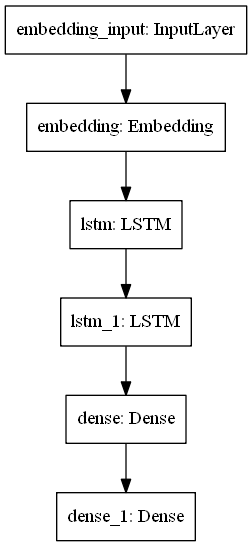

In [17]:
 # plot the model
from tensorflow import keras
from keras.utils.vis_utils import plot_model
 
keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

In [18]:
 #Train the model
from tensorflow.keras.callbacks import ModelCheckpoint
 
checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=1, batch_size=64, callbacks=[checkpoint])

345/345 [==============================] - ETA: 0s - loss: 6.2862
Epoch 00001: loss improved from inf to 6.28619, saving model to next_words.h5
345/345 [==============================] - 87s 251ms/step - loss: 6.2862


In [19]:
 #predict the model
from tensorflow.keras.models import load_model
import numpy as np
import pickle
 
# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))
 
def Predict_Next_Words(model, tokenizer, text):
 
  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""
  
  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break
  
  print(predicted_word)
  return predicted_word

In [ ]:
while(True):
    textoriginal = widgets.Text(placeholder='Enter your line: ')
    text = textoriginal.value
  
  #text = input("Enter your line: ")
  
    if text == "0":
        print("Execution completed.....")
        break
  
    else:
        try:
          text = text.split(" ")
          text = text[-3:]
          print(text)
        
          Predict_Next_Words(model, tokenizer, text)
          
        except Exception as e:
            print("Error occurred: ",e)
        continue
        
vbox_text = widgets.VBox([text])

In [ ]:
page = widgets.HBox([vbox_text])

In [ ]:
display(page)